# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv('data/movement-speeds-daily-san-francisco-2020-3.csv')

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN =  r'id="([-+]?\d[\d,.]*).+lat="([-+]?\d[\d,.]*).+lon="([-+]?\d[\d,.]*)'

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
tempdataset=node_to_gps.copy()
tempdataset.rename(columns={'osm_node_id': 'osm_start_node_id'}, inplace=True)
speeds_to_gps = speeds_to_nodes.merge(tempdataset, on='osm_start_node_id')
speeds_to_gps.dropna()
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude
0,26118026,259458979,1,64.478000,37.675280,-122.389194
1,26118026,259458979,2,62.868208,37.675280,-122.389194
2,26118026,259458979,3,62.211750,37.675280,-122.389194
3,26118026,259458979,4,62.192458,37.675280,-122.389194
4,26118026,259458979,5,61.913292,37.675280,-122.389194
...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,37.732039,-122.507126
417635,5448539901,65446993,16,25.627000,37.622476,-122.413763
417636,302964668,4069109544,19,40.802000,37.732418,-122.507206
417637,302964668,4069109544,20,36.076000,37.732418,-122.507206


### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
... # do this however you like
speeds_to_gps['plus_latitude_idx'] = speeds_to_gps['Latitude']/0.012
speeds_to_gps['plus_longitude_idx'] =speeds_to_gps['Longitude']/0.012

speeds_to_gps['plus_latitude_idx']=speeds_to_gps['plus_latitude_idx'].apply(np.floor)
speeds_to_gps['plus_longitude_idx']=speeds_to_gps['plus_longitude_idx'].apply(np.floor)

speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
0,26118026,259458979,1,64.478000,37.675280,-122.389194,3139.0,-10200.0
1,26118026,259458979,2,62.868208,37.675280,-122.389194,3139.0,-10200.0
2,26118026,259458979,3,62.211750,37.675280,-122.389194,3139.0,-10200.0
3,26118026,259458979,4,62.192458,37.675280,-122.389194,3139.0,-10200.0
4,26118026,259458979,5,61.913292,37.675280,-122.389194,3139.0,-10200.0
...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,37.732039,-122.507126,3144.0,-10209.0
417635,5448539901,65446993,16,25.627000,37.622476,-122.413763,3135.0,-10202.0
417636,302964668,4069109544,19,40.802000,37.732418,-122.507206,3144.0,-10209.0
417637,302964668,4069109544,20,36.076000,37.732418,-122.507206,3144.0,-10209.0


### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
num_pluscode_regions = len(speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx']).size().reset_index().rename(columns={0:'count'}))
num_pluscode_regions

276

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.



In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

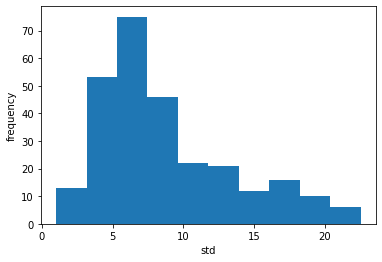

In [15]:
speeds_by_coderegion_var = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx'])['speed_mph_mean'].std().reset_index()
speed_variance_by_pluscode = speeds_by_coderegion_var['speed_mph_mean'].values

speeds_by_coderegion_var.dropna(inplace= True)

speeds_by_coderegion_mean = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx'])['speed_mph_mean'].mean().reset_index()
speeds_by_coderegion_mean.dropna(inplace= True)


plt.hist(speed_variance_by_pluscode)
plt.xlabel('std')
plt.ylabel('frequency')
average_variance_by_pluscode = speeds_by_coderegion_var['speed_mph_mean'].mean()
variance_average_by_pluscode = speeds_by_coderegion_mean['speed_mph_mean'].std()


<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

array([ 3.65023221, 20.70448741, 12.34223354,  4.08382096, 21.39091186,
        8.86860977,  3.2603851 ,  3.36171534,  4.56165023,  7.94011097,
        4.10758999,  9.43348175, 12.94054841,  3.59849774,  4.2468612 ,
        4.30603617,  5.42643479,  6.41459714,  2.55969729, 21.09837049,
        7.64659778,  3.94235217,  5.19781864,  4.90914347,  5.90691112,
        5.79137325, 16.22648321,  8.460316  ,  7.31149471,  3.76005395,
        1.14339167, 19.65422742, 22.51535842,  5.8701978 ,  8.45490931,
        9.84262937, 10.23472644,  9.48268876, 13.30741658,  4.18636057,
        8.82719389,  5.28203981,  6.09831973,  6.77817233, 21.11881139,
        6.9262261 ,  7.23608914, 12.13415641,  6.82673593,  9.00323332,
        7.88121942, 10.11736258,  8.33289174,  7.30087447,  9.90584924,
        5.51984623, 14.23931856,  5.29357043,  4.50075835, 10.15291215,
        9.51024683, 18.46086788,  7.96259449, 16.55003054,  8.55703212,
       19.68529059,  8.19286453,  8.96735644,  7.75101332, 19.56

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude))
speeds_to_points = speeds_to_points.set_crs('epsg:4326')
speeds_to_tract = speeds_to_points.sjoin(tract_to_gps, how="left")

speeds_to_tract

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
0,26118026,259458979,1,64.478000,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
1,26118026,259458979,2,62.868208,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
2,26118026,259458979,3,62.211750,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
3,26118026,259458979,4,62.192458,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
4,26118026,259458979,5,61.913292,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
...,...,...,...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,37.732039,-122.507126,3144.0,-10209.0,POINT (-122.50713 37.73204),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417635,5448539901,65446993,16,25.627000,37.622476,-122.413763,3135.0,-10202.0,POINT (-122.41376 37.62248),1456,1457,"1500 Donner Avenue, San Bruno"
417636,302964668,4069109544,19,40.802000,37.732418,-122.507206,3144.0,-10209.0,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417637,302964668,4069109544,20,36.076000,37.732418,-122.507206,3144.0,-10209.0,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"


### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract.groupby(by=["DISPLAY_NAME"])
num_census_tracts = len(speeds_to_tract['DISPLAY_NAME'].unique())
num_census_tracts

295

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



The variance within and between the census defined clusters seems pretty similar; if the variability in speed values within cluster isn't smaller than the one between clusters, then it's not clear that clusters are highly informative and capture the meaningful within-cluster information.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

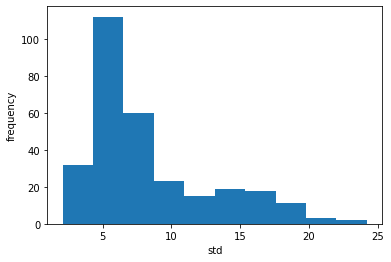

In [24]:
speed_variance_by_tract = speeds_by_tract['speed_mph_mean'].std().values
plt.hist(speeds_by_tract['speed_mph_mean'].std().values)
plt.xlabel('std')
plt.ylabel('frequency')
average_variance_by_tract = speeds_by_tract['speed_mph_mean'].std().values.mean()
variance_average_by_tract = speeds_by_tract['speed_mph_mean'].mean().values.std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [25]:
speed_variance_by_tract

array([ 8.61490605,  5.26784153,  4.19015424,  7.83474971,  3.56550056,
        6.84782114, 11.71402651, 18.12074609, 11.54283441, 24.21563906,
       14.38086286,  7.77364207, 23.01327049,  6.0806499 ,  5.99245463,
        5.35763179,  6.60557924, 17.31239552,  3.68100216, 14.3125177 ,
        7.86643453, 12.75420486,  3.49955697,  4.87750821,  7.74000647,
       19.44509198,  6.2899601 , 14.07564718,  3.58112143,  9.88126588,
       16.27435271,  7.11290696,  5.47760625,  7.40922341, 14.548944  ,
        5.87201944, 10.61318937,  5.2030326 ,  4.05630133,  5.29418423,
        4.46340478, 12.97766622,  5.43985931,  2.07754782, 15.02741332,
        9.48246932,  8.82104668,  5.45309776,  5.96241257,  8.04983875,
       14.06555836,  5.76108898,  4.95476344, 14.56101697, 12.35859789,
       15.69461223, 13.73907256, 17.96568193,  6.15602926, 17.35095681,
        7.46761657, 16.09817384,  7.70853556,  5.88637344, 10.64913224,
       12.73159639,  6.28433134,  5.59593174,  4.85365216,  3.66

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

1. A good metric for spatial structure would minimize the variability within cluster and mazimize the between cluster variability (while at the same time handling the tradeoff of now making the clusters too small (i.e. single point) which would be expensive.
2. I would combine the metric described in Q1, but would also want to make the clusters more informative (for instance, adding the number of vehicles per cluster, variability during the day etc.)

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

Slowest speeds pre lock down seem to be observed in downtown SF mainly, probably because that area has busy traffic and this was before lockdown. On the other hand, areas in south bay/sausalito etc. had highest average speeds - maybe because freeways are there which allow for higher speed during non-rush hour times. This would match my predictions. 

The long tail distribution of high speed traffic in San Francisco probably corresponds to areas outside of downtown/busy traffic/residential areas - but mostly traffic is slow in SF so these would have to be scattered few areas. 

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [27]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
prelockdown=speeds_to_tract.loc[(speeds_to_tract['day']>=1) & (speeds_to_tract['day']<=13),:]
averages_pre = prelockdown.groupby('DISPLAY_NAME')['speed_mph_mean'].agg('mean').sort_values(ascending=True)
# polygon for census tract, and average speed per census tract
sortedPrenamed=pd.DataFrame(prelockdown.groupby('DISPLAY_NAME')['speed_mph_mean'].agg('mean').sort_values(ascending=True))

averages_pre_named = sortedPrenamed.merge(tract_to_gps, on='DISPLAY_NAME')
averages_pre_named

,DISPLAY_NAME,speed_mph_mean,MOVEMENT_ID,geometry
0,"200 O'Farrell Street, Tenderloin, San Francisco",12.417079,1691,"MULTIPOLYGON (((-122.41462 37.78558, -122.4129..."
1,"0 Mason Street, Tenderloin, San Francisco",12.595120,2340,"MULTIPOLYGON (((-122.41405 37.78279, -122.4107..."
2,"1100 Taylor Street, Nob Hill, San Francisco",12.945291,1688,"MULTIPOLYGON (((-122.41629 37.79389, -122.4152..."
3,"2900 22nd Street, Mission District, San Francisco",13.195865,651,"MULTIPOLYGON (((-122.41672 37.75717, -122.4123..."
4,"200 Myrtle Street, Tenderloin, San Francisco",13.490311,643,"MULTIPOLYGON (((-122.42146 37.78663, -122.4182..."
...,...,...,...,...
290,"1200 Helen Drive, Millbrae",45.492292,1744,"MULTIPOLYGON (((-122.42820 37.60497, -122.4263..."
291,"Frenchmans Creek Road, Half Moon Bay",47.225137,2339,"MULTIPOLYGON (((-122.46816 37.56079, -122.4605..."
292,"Petrolite Street, Richmond",47.318340,1653,"MULTIPOLYGON (((-122.42976 37.96540, -122.4185..."
293,"4200 Shelter Creek Lane, San Bruno",53.867847,495,"MULTIPOLYGON (((-122.43101 37.61999, -122.4300..."


Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [29]:
bottom10_averages_pre = averages_pre_named.iloc[0:10,:]
bottom10_averages_pre

,DISPLAY_NAME,speed_mph_mean,MOVEMENT_ID,geometry
0,"200 O'Farrell Street, Tenderloin, San Francisco",12.417079,1691,"MULTIPOLYGON (((-122.41462 37.78558, -122.4129..."
1,"0 Mason Street, Tenderloin, San Francisco",12.595120,2340,"MULTIPOLYGON (((-122.41405 37.78279, -122.4107..."
2,"1100 Taylor Street, Nob Hill, San Francisco",12.945291,1688,"MULTIPOLYGON (((-122.41629 37.79389, -122.4152..."
3,"2900 22nd Street, Mission District, San Francisco",13.195865,651,"MULTIPOLYGON (((-122.41672 37.75717, -122.4123..."
4,"200 Myrtle Street, Tenderloin, San Francisco",13.490311,643,"MULTIPOLYGON (((-122.42146 37.78663, -122.4182..."
5,"200 Sutter Street, Financial District, San Fra...",13.502505,1689,"MULTIPOLYGON (((-122.40879 37.79016, -122.4071..."
6,"800 Jackson Street, Chinatown, San Francisco",13.549474,1244,"MULTIPOLYGON (((-122.41172 37.79629, -122.4084..."
7,"500 Geary Street, Tenderloin, San Francisco",13.570625,1245,"MULTIPOLYGON (((-122.41500 37.78745, -122.4133..."
8,"200 Jones Street, Tenderloin, San Francisco",13.626251,644,"MULTIPOLYGON (((-122.41443 37.78466, -122.4127..."
9,"200 Hyde Street, Tenderloin, San Francisco",13.944773,1674,"MULTIPOLYGON (((-122.41771 37.78424, -122.4160..."


Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [31]:
top10_averages_pre = averages_pre_named.iloc[-10:]
top10_averages_pre

,DISPLAY_NAME,speed_mph_mean,MOVEMENT_ID,geometry
285,"600 San Bruno Avenue East, San Bruno",38.944079,1743,"MULTIPOLYGON (((-122.41676 37.63935, -122.4115..."
286,"0 Longview Drive, Westlake, Daly City",40.587037,1732,"MULTIPOLYGON (((-122.50053 37.70083, -122.4961..."
287,"Liccicitos Road, Moss Beach",42.784267,1955,"MULTIPOLYGON (((-122.52036 37.57534, -122.5180..."
288,"0 Burgess Court, Sausalito",43.848188,2660,"MULTIPOLYGON (((-122.52032 37.87046, -122.5193..."
289,"0 Crystal Springs Terrace, Hillsborough Park, ...",44.304919,2244,"MULTIPOLYGON (((-122.37189 37.54776, -122.3710..."
290,"1200 Helen Drive, Millbrae",45.492292,1744,"MULTIPOLYGON (((-122.42820 37.60497, -122.4263..."
291,"Frenchmans Creek Road, Half Moon Bay",47.225137,2339,"MULTIPOLYGON (((-122.46816 37.56079, -122.4605..."
292,"Petrolite Street, Richmond",47.318340,1653,"MULTIPOLYGON (((-122.42976 37.96540, -122.4185..."
293,"4200 Shelter Creek Lane, San Bruno",53.867847,495,"MULTIPOLYGON (((-122.43101 37.61999, -122.4300..."
294,"1600 Maritime Street, Oakland",59.498552,285,"MULTIPOLYGON (((-122.33037 37.82058, -122.3161..."


<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

Text(0, 0.5, 'count')

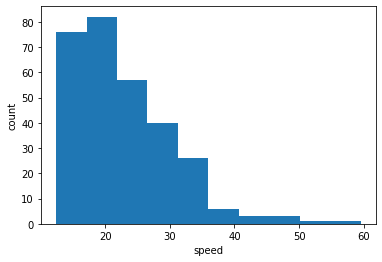

In [33]:
plt.hist(averages_pre_named['speed_mph_mean'])
plt.xlabel('speed')
plt.ylabel('count')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

The range of average speeds increased post lock down, in that the highest speed became 70 instead of 60. average has shifted as well, from around 22 mph to 28. This is kind of in line with the intuition that lockdown reduced traffic and thus could have led to an increase in average speed.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [34]:
postlockdown=speeds_to_tract.loc[(speeds_to_tract['day']>=14),:]

# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
averages_post = postlockdown.groupby('DISPLAY_NAME')['speed_mph_mean'].agg('mean').sort_values(ascending=True)

# polygon for census tract, and average speed per census tract
sortedPostnamed=pd.DataFrame(postlockdown.groupby('DISPLAY_NAME')['speed_mph_mean'].agg('mean').sort_values(ascending=True))

averages_post_named = sortedPostnamed.merge(tract_to_gps, on='DISPLAY_NAME')
averages_post_named

,DISPLAY_NAME,speed_mph_mean,MOVEMENT_ID,geometry
0,"1100 Taylor Street, Nob Hill, San Francisco",13.947161,1688,"MULTIPOLYGON (((-122.41629 37.79389, -122.4152..."
1,"200 O'Farrell Street, Tenderloin, San Francisco",14.157774,1691,"MULTIPOLYGON (((-122.41462 37.78558, -122.4129..."
2,"2900 22nd Street, Mission District, San Francisco",14.355647,651,"MULTIPOLYGON (((-122.41672 37.75717, -122.4123..."
3,"2600 Broadway, Pacific Heights, San Francisco",14.960722,1258,"MULTIPOLYGON (((-122.44673 37.79471, -122.4402..."
4,"2100 Divisadero Street, Pacific Heights, San F...",15.219232,1259,"MULTIPOLYGON (((-122.44612 37.79100, -122.4394..."
...,...,...,...,...
280,"4200 Shelter Creek Lane, San Bruno",65.053061,495,"MULTIPOLYGON (((-122.43101 37.61999, -122.4300..."
281,"Frenchmans Creek Road, Half Moon Bay",66.958324,2339,"MULTIPOLYGON (((-122.46816 37.56079, -122.4605..."
282,"1200 Helen Drive, Millbrae",67.013959,1744,"MULTIPOLYGON (((-122.42820 37.60497, -122.4263..."
283,"0 Crystal Springs Terrace, Hillsborough Park, ...",69.823830,2244,"MULTIPOLYGON (((-122.37189 37.54776, -122.3710..."


Text(0, 0.5, 'count')

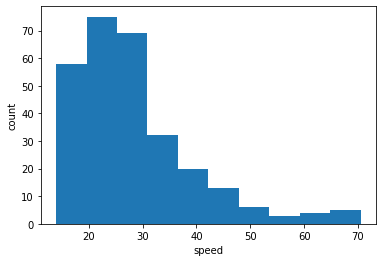

In [36]:
plt.hist(averages_post_named['speed_mph_mean'])
plt.xlabel('speed')
plt.ylabel('count')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

Text(0, 0.5, 'count')

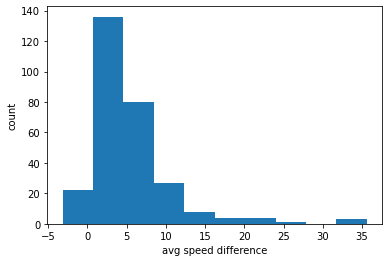

In [37]:
# series object with index
# MOVEMENT_ID.

post_lock=speeds_to_tract.loc[speeds_to_tract['day']>=14].groupby('MOVEMENT_ID')['speed_mph_mean'].agg('mean').reset_index()
pre_lock=speeds_to_tract.loc[speeds_to_tract['day']<=13].groupby('MOVEMENT_ID')['speed_mph_mean'].agg('mean').reset_index()
post_post_merge = post_lock.merge(pre_lock,on='MOVEMENT_ID')

post_post_merge['diff'] = post_post_merge['speed_mph_mean_x'] - post_post_merge['speed_mph_mean_y']
post_post_merge.set_index('MOVEMENT_ID',inplace=True)




differences = post_post_merge['diff'] #speeds_to_tract.loc[speeds_to_tract['day']>=14].groupby('MOVEMENT_ID')['speed_mph_mean'].agg('mean')-speeds_to_tract.loc[speeds_to_tract['day']<=13].groupby('MOVEMENT_ID')['speed_mph_mean'].agg('mean')
# plot the differences
plt.hist(differences)
plt.xlabel('avg speed difference')
plt.ylabel('count')





<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

Text(0, 0.5, 'avg speed')

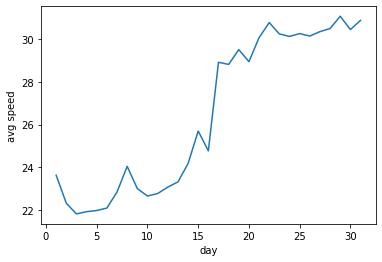

In [39]:
# series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby(['day'])['speed_mph_mean'].agg('mean')
plt.plot(speeds_daily)
plt.xlabel('day')
plt.ylabel('avg speed')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Notes:
<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

Speed is sharply increasing around the day 14 when shelter in place order came out, probably because the shelter in place order made sure people are staying inside, leaving the traffic empty for people to drive faster. It might also be worth noting that there is an increase from day 5 to 15 as well that looks sharp. 

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [41]:
post_speed = post_post_merge["speed_mph_mean_x"]
pre_speed = post_post_merge["speed_mph_mean_y"]
diff = post_post_merge["diff"]

corr_pre_diff = pre_speed.corr(diff)
corr_post_diff = post_speed.corr(diff)
corr_pre_diff, corr_post_diff

(0.4633006380580186, 0.7926799984780658)

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

Lowest speeds in san francisco city area - makes sense because the busy traffic would limit speed (since this was before pandemic)
regions in south bay and east bay look quite similar.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

<AxesSubplot:>

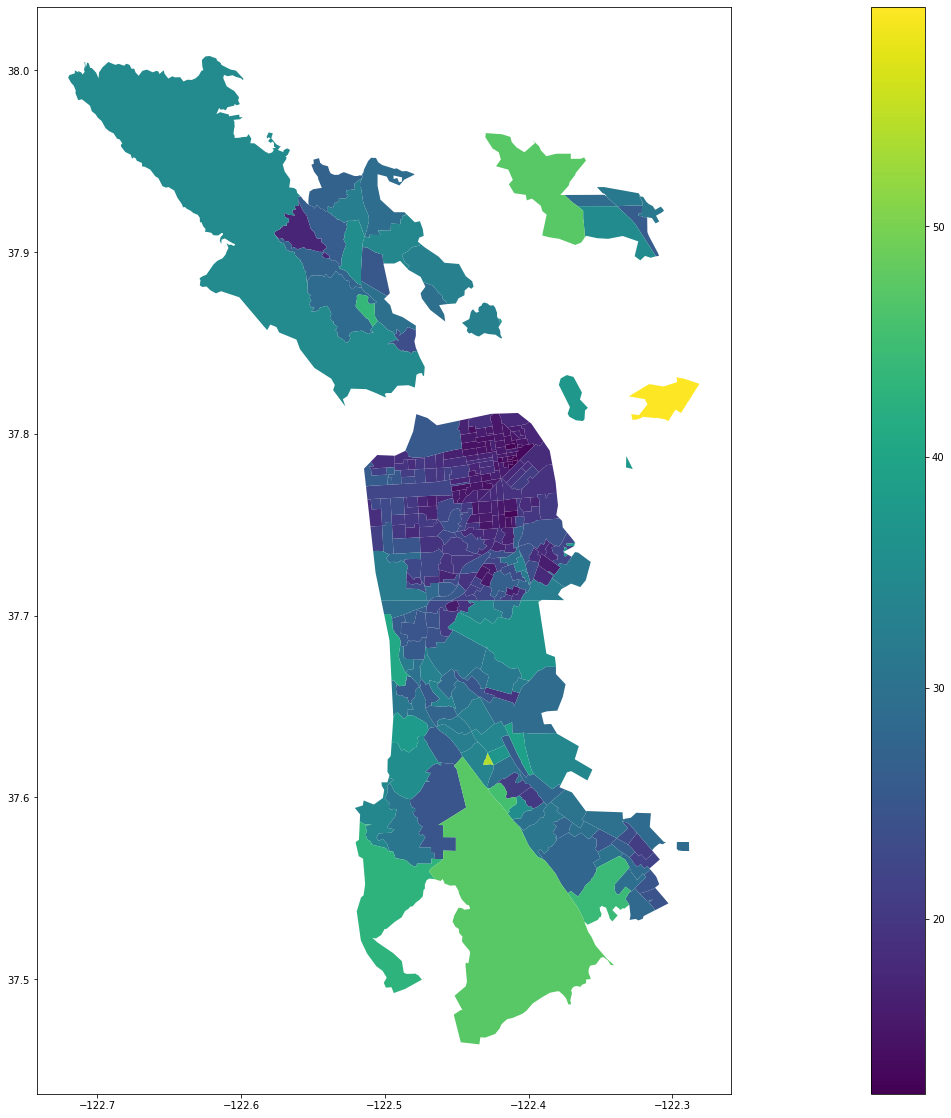

In [43]:

gdf = gpd.GeoDataFrame(
    averages_pre_named, geometry=(averages_pre_named.geometry))

gdf = gdf.set_crs('epsg:4326')

gdf.plot(column='speed_mph_mean',figsize=(50, 20),legend=True)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

Pattern1: Most affected were the areas that showed highest speed before the lockdown, in that they showed higher increase in speed post lockdown.

Pattern2:  The SF city area looks pretty much the same pre and after lockdown (not affected). 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

<AxesSubplot:>

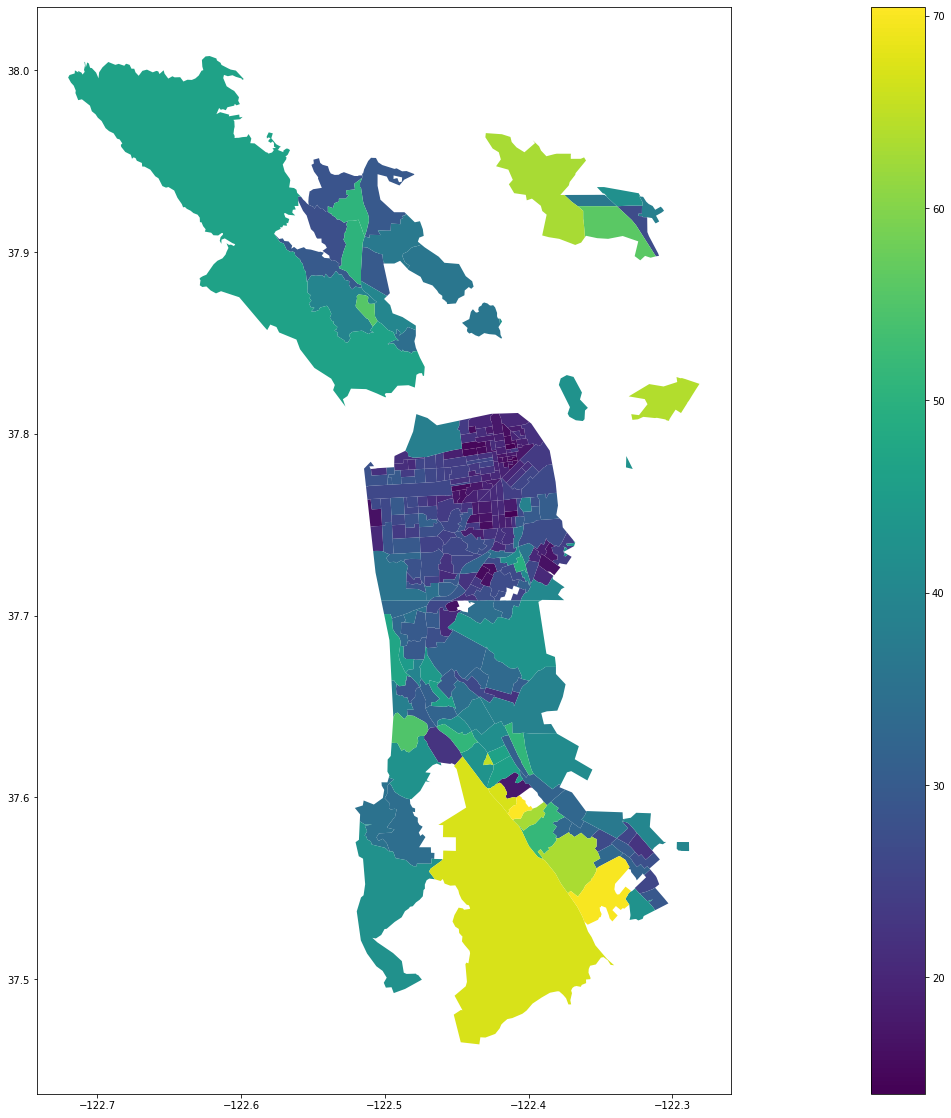

In [44]:
gdf_post = gpd.GeoDataFrame(
    averages_post_named, geometry=(averages_post_named.geometry))

gdf_post = gdf_post.set_crs('epsg:4326')

gdf_post.plot(column='speed_mph_mean',figsize=(50, 20),legend=True)

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [45]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)

# convert the date column to single day for easier readability; days are 1-31, with 13. being when the lockdown was announced. 

times_to_tract['mean travel time (hours)'] = times_to_tract['Mean Travel Time (Seconds)']/(60*60)
times_to_tract['Day'] =times_to_tract['Date Range'].apply(lambda x: int(re.search(r'3\/(.*?)/2020',str(x)).group(1)))

# separate the dataframe into pre and post 
preLockDownHayesValley = times_to_tract.loc[times_to_tract['Day']<=13]
postLockDownHayesValley = times_to_tract.loc[times_to_tract['Day']>=14]

preHVgroup=preLockDownHayesValley.groupby(['Origin Movement ID','Destination Movement ID'])['Mean Travel Time (Seconds)'].agg('mean').reset_index()
postHVgroup=postLockDownHayesValley.groupby(['Origin Movement ID','Destination Movement ID'])['Mean Travel Time (Seconds)'].agg('mean').reset_index()
preHVgroup.rename(columns={'Mean Travel Time (Seconds)': 'Pre Lock Travel Time'}, inplace=True)
postHVgroup.rename(columns={'Mean Travel Time (Seconds)': 'Post Lock Travel Time'}, inplace=True)

combinePrePost=pd.merge(preHVgroup, postHVgroup,  how='right', left_on=['Origin Movement ID','Destination Movement ID'], right_on = ['Origin Movement ID','Destination Movement ID'])
combinePrePost['PrePostDifference'] = combinePrePost['Post Lock Travel Time'] - combinePrePost['Pre Lock Travel Time']



Text(0.5, 1.0, 'Average travel time across days in March')

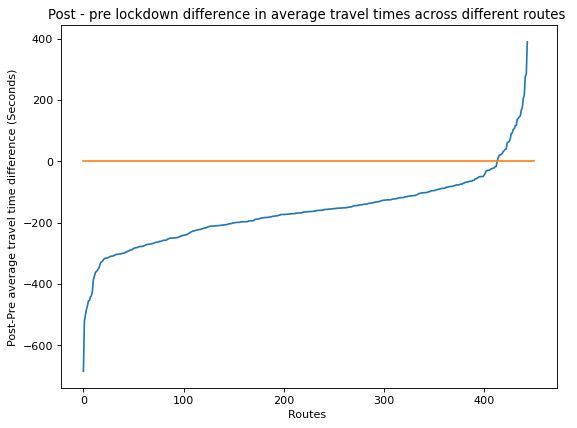

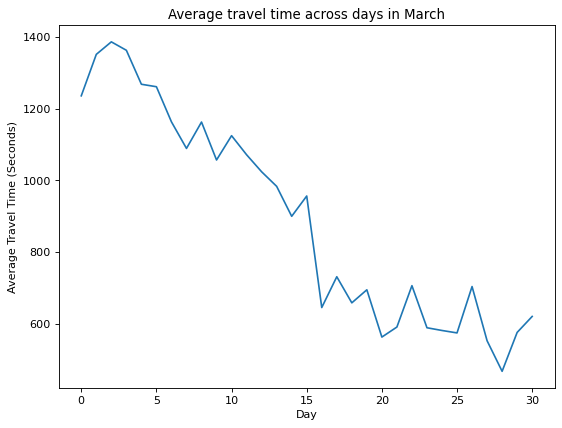

In [46]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(combinePrePost['PrePostDifference'].sort_values(ascending=True).values)
plt.plot([0,450],[0,0])
plt.ylabel('Post-Pre average travel time difference (Seconds)')
plt.xlabel('Routes ')
plt.title('Post - pre lockdown difference in average travel times across different routes ')

figure(figsize=(8, 6), dpi=80)
plt.plot(times_to_tract.groupby('day')['Mean Travel Time (Seconds)'].agg('mean').values)
plt.xlabel('Day')
plt.ylabel('Average Travel Time (Seconds)')
plt.title('Average travel time across days in March')



/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


<AxesSubplot:>

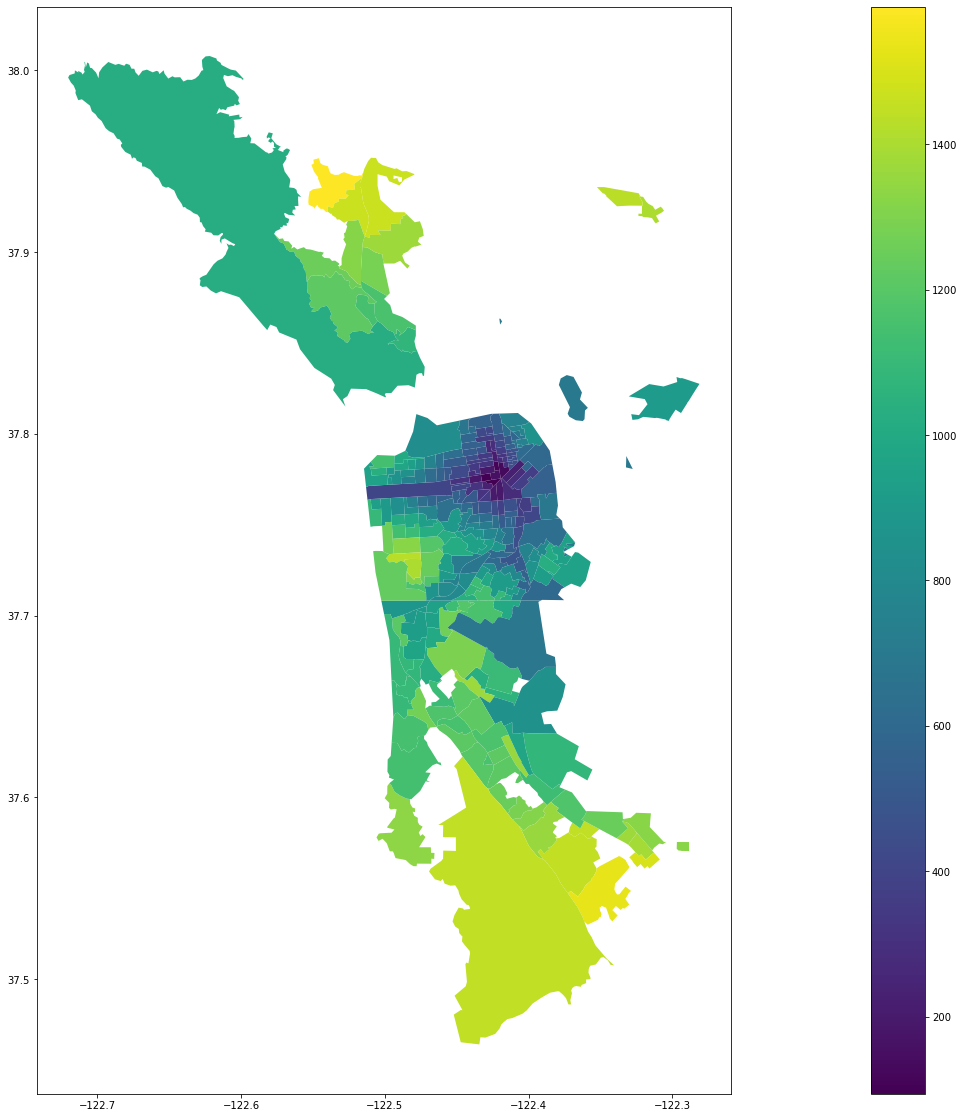

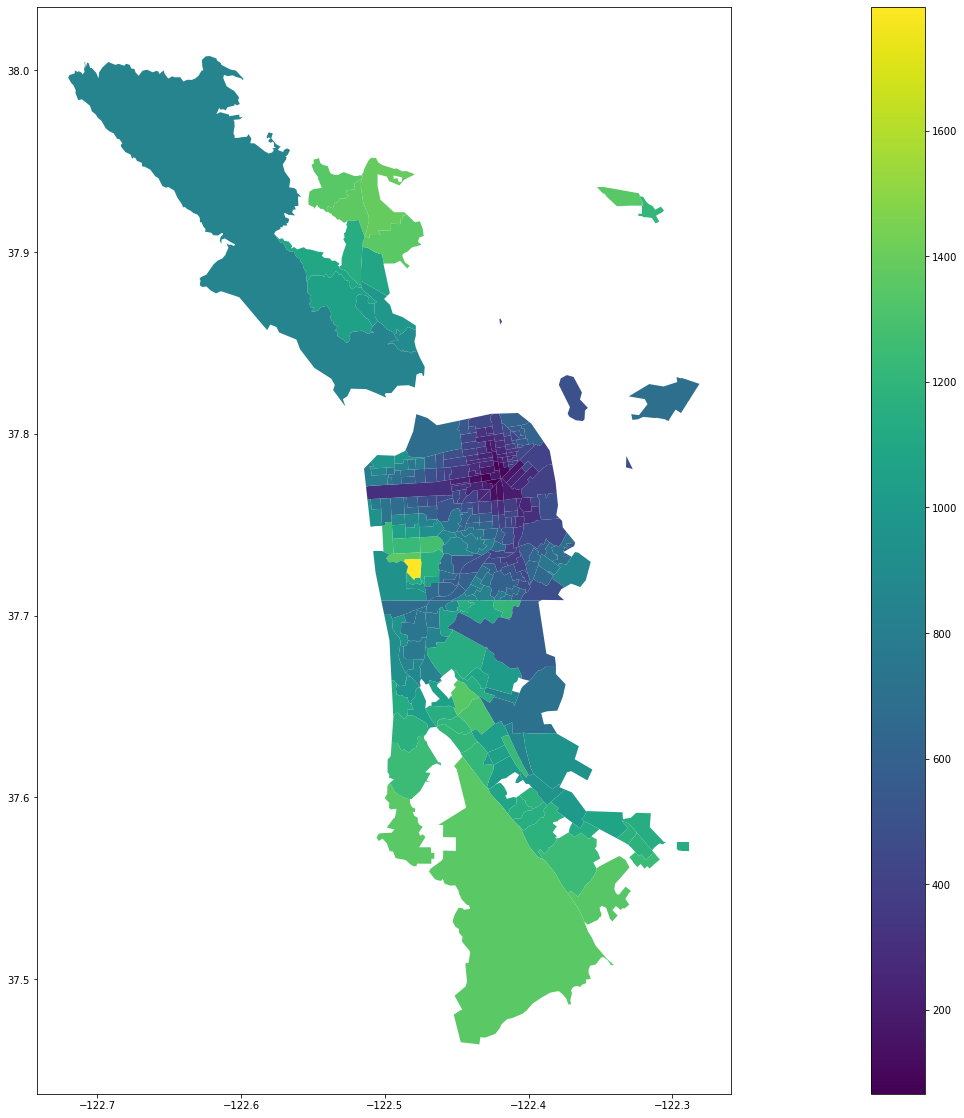

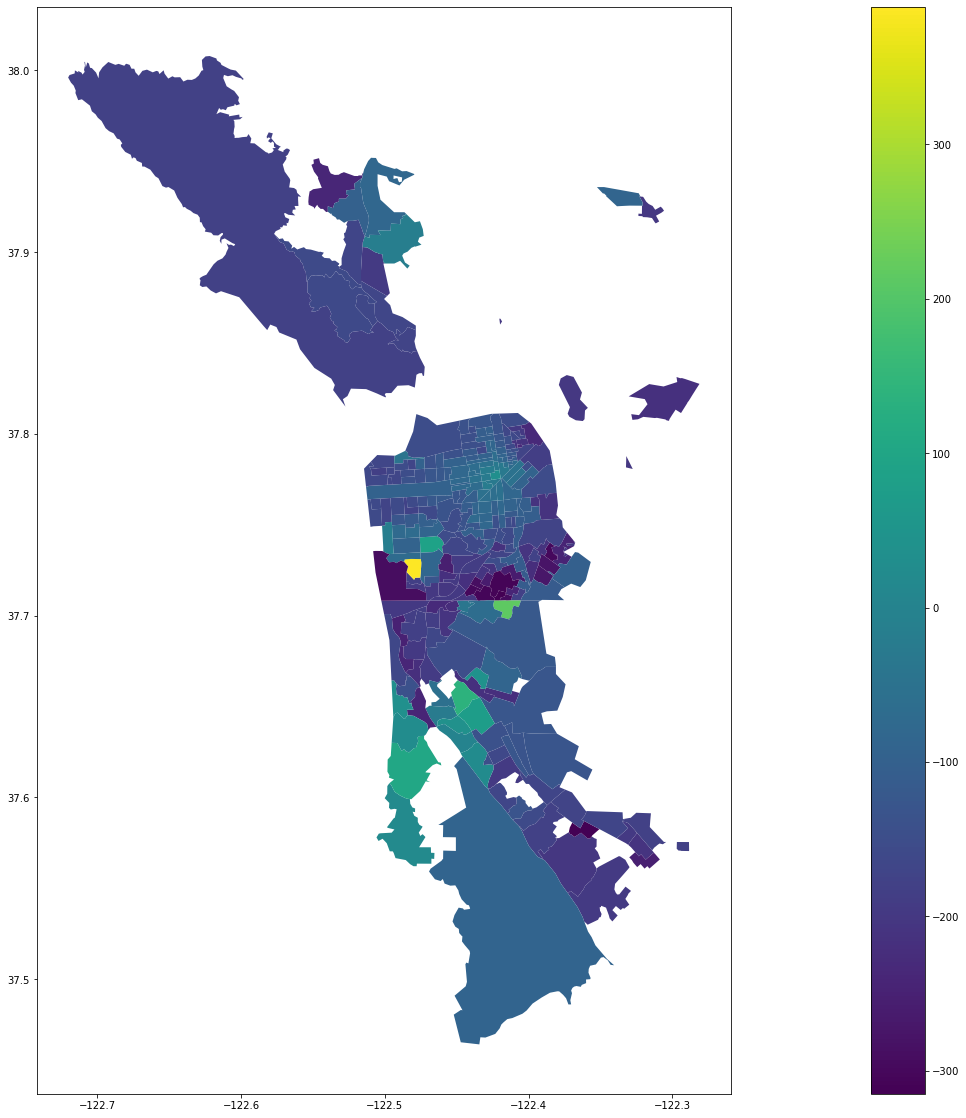

In [47]:
preMovementGeometry = averages_pre_named[['MOVEMENT_ID','geometry']]
preMovementGeometry.rename(columns={'MOVEMENT_ID':'Destination Movement ID'},inplace=True)
preMovementGeometry=preMovementGeometry.merge(combinePrePost, on='Destination Movement ID')
gdf_preMovementDestinations = gpd.GeoDataFrame(
    preMovementGeometry, geometry=(preMovementGeometry.geometry))

gdf_preMovementDestinations = gdf_preMovementDestinations.set_crs('epsg:4326')


from mpl_toolkits.axes_grid1 import make_axes_locatable
#ax = plt.subplots(1, 1)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="10%", pad=0.1)
gdf_preMovementDestinations.plot(column='Pre Lock Travel Time', figsize=(50, 20),legend=True)
gdf_preMovementDestinations.plot(column='Post Lock Travel Time', figsize=(50, 20),legend=True)
gdf_preMovementDestinations.plot(column='PrePostDifference', figsize=(50, 20),legend=True)




In [48]:
combinePrePost['AbsDifference']=abs(combinePrePost['PrePostDifference'])
areaNamesAndIDs = times_to_tract[['Destination Movement ID','Destination Display Name']]
areaNamesAndIDs['Destination Display Name'].astype(str)
combinePrePost1= pd.merge(combinePrePost, areaNamesAndIDs, on="Destination Movement ID", how='inner')#areaNamesAndIDs.merge(combinePrePost, on='Destination Movement ID')

# most affected (overall) by the lockdown
combinePrePost1.sort_values(by='AbsDifference',ascending=False).drop_duplicates().reset_index().head(20)



,index,Origin Movement ID,Destination Movement ID,Pre Lock Travel Time,Post Lock Travel Time,PrePostDifference,AbsDifference,Destination Display Name
0,7639,1277,1831,2887.111111,2203.000000,-684.111111,684.111111,"1100 East Arques Avenue, Sunnyvale"
1,5186,1277,1302,2816.076923,2296.000000,-520.076923,520.076923,"Tasman Drive, Santa Clara"
2,1929,1277,554,2701.538462,2200.333333,-501.205128,501.205128,"200 2nd Street, Sunnyvale"
3,7892,1277,2169,2663.153846,2180.000000,-483.153846,483.153846,"1000 Liege Terrace, Morse Park, Sunnyvale"
4,1000,1277,306,2703.416667,2231.666667,-471.750000,471.750000,"200 Silverlake Drive, Lakewood, Sunnyvale"
5,407,1277,108,1923.714286,1469.000000,-454.714286,454.714286,"400 West Sunset Boulevard, Hayward"
6,9249,1277,2525,2798.583333,2345.000000,-453.583333,453.583333,"1200 Elko Drive, Sunnyvale"
7,7657,1277,1833,2566.307692,2124.200000,-442.107692,442.107692,"500 Logue Avenue, Mountain View"
8,1939,1277,555,2806.375000,2368.000000,-438.375000,438.375000,"500 Aldo Avenue, Santa Clara"
9,4198,1277,1097,1907.000000,1485.000000,-422.000000,422.000000,"15500 Tracy Street, San Lorenzo"


In [49]:
# least affected (overall) by the lockdown 
combinePrePost1.sort_values(by='AbsDifference',ascending=True).drop_duplicates().reset_index().head(20)


,index,Origin Movement ID,Destination Movement ID,Pre Lock Travel Time,Post Lock Travel Time,PrePostDifference,AbsDifference,Destination Display Name
0,1910,1277,543,1209.846154,1211.000000,1.153846,1.153846,"2500 Carmel Drive, San Bruno"
1,2000,1277,598,1458.500000,1471.000000,12.500000,12.500000,"3000 Colby Street, Elmwood, Berkeley"
2,8103,1277,2281,1370.692308,1354.000000,-16.692308,16.692308,"0 Corte Palos Verdes, Tiburon, Belvedere Tiburon"
3,8495,1277,2323,1257.307692,1240.000000,-17.307692,17.307692,"2600 40th Avenue, Sunset District, San Francisco"
4,5429,1277,1456,1336.000000,1356.000000,20.000000,20.000000,"Montara Mountain Trail, Pacifica"
5,7670,1277,1834,2380.500000,2401.000000,20.500000,20.500000,"500 Castro Street, Old Mountain View, Mountain..."
6,8253,1277,2314,230.461538,209.555556,-20.905983,20.905983,"300 Waller Street, Western Addition, San Franc..."
7,4736,1277,1276,190.384615,168.333333,-22.051282,22.051282,"1100 Golden Gate Avenue, Western Addition, San..."
8,2817,1277,678,1194.615385,1217.428571,22.813187,22.813187,"2500 Crestmoor Drive, San Bruno"
9,1826,1277,537,93.692308,70.000000,-23.692308,23.692308,"500 Webster Street, Western Addition, San Fran..."


Text(0.5, 1.0, 'Pre-Lockdown')

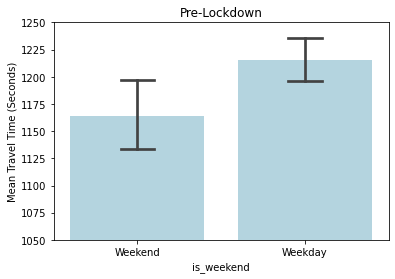

In [50]:
import seaborn as sns
weekends = np.array([1,7,8,14,15,21,22,28,29])

times_to_tract['is_weekend'] = times_to_tract['day'].apply(lambda x: any(x == weekends)).astype(int)
times_to_tract['is_weekend'] = times_to_tract['is_weekend'].replace({1:'Weekend', 0:'Weekday'})

times_by_wkd = times_to_tract.pivot_table(columns = 'is_weekend', index = 'Destination Display Name', values = 'Mean Travel Time (Seconds)').dropna()

times_by_wkd['Difference'] = times_by_wkd['Weekday'] - times_by_wkd['Weekend']
times_by_wkd = times_by_wkd.sort_values('Difference', ascending=False)

times_to_tract_pre = times_to_tract.query('day < 14')
times_to_tract_post = times_to_tract.query('day >= 14')
#making the first plot

times_to_tract_pre
ax = sns.barplot(x="is_weekend", y="Mean Travel Time (Seconds)", data=times_to_tract_pre, estimator=np.mean, ci=95, capsize=.2, color='lightblue')
ax.set_ylim(1050,1250)
ax.set_title('Pre-Lockdown')



(600.0, 800.0)

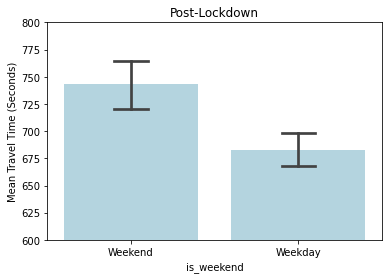

In [51]:
ax = sns.barplot(x="is_weekend", y="Mean Travel Time (Seconds)", data=times_to_tract_post, estimator=np.mean, ci=95, capsize=.2, color='lightblue')
ax.set_title('Post-Lockdown')
ax.set_ylim(600,800)

Hayes Valley - South Bay ( Sunnyvale/Mountain View), Hayes Valley - Sausalito, Hayes Valley - East Bay show similar patterns. The travel time is overall reduced post lockdown. These are likely freeways/bridges that were not busy post-lockdown, resulting in reduced travel times.  


The areas closer to Hayes Valley in proximity show somewhat positive change post-lockdown (although this doesn't look super convincing), suggesting that residential areas might have had a slight increase in travel time (could be explained by people avoiding being around other people and opting to drive when necessary instead).


There are a few segments that actually increase in travel time post lockdown, which could possibly be a data artifact (i.e. not a lot of data points for this destination with some outliers, resulting in inflated averages).

Travel times are lower on weekends compared to workdays before lockdown, and reverse post-lockdown.  

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [52]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    #xdf=df[['MOVEMENT_ID','day','speed_mph_mean']]

    return (df[['MOVEMENT_ID','day','speed_mph_mean']].pivot_table(values='speed_mph_mean', index='MOVEMENT_ID', columns='day', aggfunc='mean'))

time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]


In [54]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    
    
    if n_val != 0:
    
        validx=list(range(len(df.columns)))[-n_val:]
        ### training
        X_train= np.array(df.iloc[:, list(range(0,T))])
        y_train= df.iloc[:, T].values
        for i in range(1,validx[0]-T):
            X_train=np.append(X_train,np.array(df.iloc[:, list(range(i,i+T))]),axis=0)

        for i in range(T+1,validx[0]):
            y_train=np.append(y_train, df.iloc[:, i].values)
        
        
    
    
        ### validation
    
        y_val=df.iloc[:,validx[0]].values
        X_val = np.array(df.iloc[:, list(range(validx[0]-T,validx[0]))])
        for i in validx[1:]:
            X_val = np.append(X_val,np.array(df.iloc[:, list(range(i-T,i))]),axis=0)
            y_val = np.append(y_val,df.iloc[:,i].values)

        return X_train,y_train,X_val,y_val
    
    else:
        
#         validx=list(range(len(df.columns)))[-n_val:]
#         print(validx)
        ### training
        X_train= np.array(df.iloc[:, list(range(0,T))])
        y_train= df.iloc[:, T].values
        

        for i in range(1,len(df.columns)-T):
            X_train=np.append(X_train,np.array(df.iloc[:, list(range(i,i+T))]),axis=0)

        for i in range(T+1,len(df.columns)):
            y_train=np.append(y_train, df.iloc[:, i].values)       
        
#         ##########################################
        y_val= df.iloc[:,13].values
        X_val = np.array(df.iloc[:, list(range(13-T,13))])
        
        for i in list(range(14,len(df.columns))):
            X_val = np.append(X_val,np.array(df.iloc[:, list(range(i-T,i))]),axis=0)
            y_val = np.append(y_val,df.iloc[:,i].values)

        return X_train,y_train,X_val,y_val        
    

    
def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    
    if not len(X):
        return X, y
    else:
        isnanlist=[]
        for i in range(len(X)):
            
            isnanlist.append(np.sum(np.isnan(X[i]))>0 or np.isnan(y[i])==True)
        
        isnanlist=[not elem for elem in isnanlist]

        return X[isnanlist],y[isnanlist]
    
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [56]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    pre_answer=time_series_to_numpy(time_series,T,n_val)
    X_train,y_train=remove_nans(pre_answer[0],pre_answer[1])    
    X_val,y_val=remove_nans(pre_answer[2],pre_answer[3])
    return X_train, y_train, X_val, y_val
    
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [58]:
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [59]:
time_series_pre

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,13.739901,14.391436,13.955833
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,13.790100,14.573349,15.177251
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,NaN,22.107000,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,23.870537,20.215396,20.343131


In [60]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

In [61]:
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_train,y_train)
y_fitted_m1 = linear_model.predict(X_train)
y_predicted_m1 = linear_model.predict(X_val)

In [62]:
#from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)


reg = linear_model.fit(X_train,y_train) #... # set to trained linear model
#linear_model.fit(X_train,y_train)
y_fitted_m1 = reg.predict(X_train)
y_predicted_m1 = reg.predict(X_val)


TSS=np.sum((y_val-np.mean(y_val))**2)
RSS=np.sum((y_val-y_predicted_m1)**2)

score = 1-(RSS/TSS) # report r^2 score
# create the scatter plot below

Text(0, 0.5, 'y')

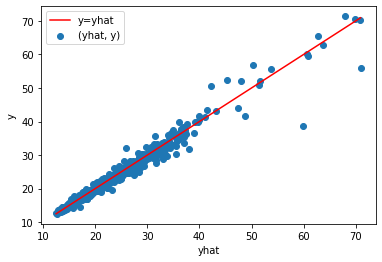

In [63]:
plt.figure()
plt.scatter(y_predicted_m1, y_val, label = "(yhat, y)")
cmin  =max(np.min(y_predicted_m1), np.min(y_val))
cmax = min(np.max(y_predicted_m1),np.max(y_val))
plt.plot([cmin,cmax],[cmin,cmax],
color ="red",
label = "y=yhat")
plt.legend()
plt.xlabel('yhat')
plt.ylabel('y')

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [64]:
score

0.9639232922122069

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [66]:
time_series_x_pre = np.array(time_series.iloc[:,list(np.array([9, 10, 11, 12, 13])-1)]) # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post = time_series.iloc[:,13].values # get 'time series' dataframe for 14th


time_series_x_pre,time_series_y_post=remove_nans(time_series_x_pre,time_series_y_post)
predicted_y_post = reg.predict(time_series_x_pre)


TSS_pre=np.sum((time_series_y_post-np.mean(time_series_y_post))**2)
RSS_pre=np.sum((time_series_y_post-predicted_y_post)**2)

score_pre_14th = 1-(RSS_pre/TSS_pre)
score_pre_14th

0.9337122097376677

In [68]:
time_series_x_pre

array([[14.84532001, 14.71153361, 13.73990125, 14.3914358 , 13.95583259],
       [16.17810543, 15.29549397, 14.63710904, 14.28260209, 14.43735825],
       [15.61621536, 14.85047114, 13.79010039, 14.57334878, 15.17725078],
       ...,
       [20.4970768 , 20.40108451, 23.8705369 , 20.2153963 , 20.34313065],
       [32.17986695, 32.9518555 , 31.57452517, 32.17295775, 31.33436375],
       [25.51240295, 24.88606305, 23.90259874, 25.26272056, 24.45002487]])

In [69]:
time_series_y_post

array([15.87805614, 16.09538544, 15.17225238, 25.00645192, 15.1288    ,
       16.7048158 , 18.77729159, 23.98522813, 25.03852101, 30.76832456,
       17.77197562, 18.11368942, 28.02313988, 20.82763148, 17.42694207,
       18.22003466, 28.26654435, 29.32978935, 20.73002755, 17.33082953,
       25.213125  , 35.62818654, 60.35547222, 15.25889038, 18.61711905,
       30.73814813, 31.88187256, 31.3947788 , 31.81918147, 25.88585606,
       18.56674462, 18.16756015, 17.15433443, 16.00452038, 60.76129862,
       30.60442575, 18.3730735 , 18.81192524, 17.6888209 , 23.05320108,
       17.52912136, 16.30571395, 26.5748976 , 35.29862818, 38.50747421,
       19.46483041, 15.82690418, 17.80623106, 15.38788273, 14.12497315,
       16.23102798, 15.26397466, 16.07743469, 16.74570089, 22.65961155,
       28.44381007, 13.91921591, 30.9269172 , 20.37785778, 21.22272118,
       20.00507443, 23.90197941, 23.69164573, 19.11505735, 29.0305431 ,
       27.62038497, 31.07392876, 25.43576819, 35.83537867, 35.40

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

Text(0, 0.5, 'y')

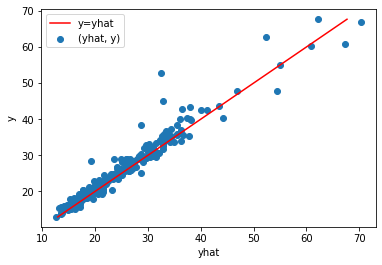

In [70]:
plt.figure()
plt.scatter(predicted_y_post,time_series_y_post, label = "(yhat, y)")
cmin  =max(np.min(predicted_y_post), np.min(time_series_y_post))
cmax = min(np.max(predicted_y_post),np.max(time_series_y_post))
plt.plot([cmin,cmax],[cmin,cmax],
color ="red",
label = "y=yhat")
plt.legend()
plt.xlabel('yhat')
plt.ylabel('y')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



2. the lowest performance is at day 17 (around .75)

3. the model dips at 17, because 17th is after the lockdown, when we know the speed was significantly different compared to pre lockdown , and the model is using data from pre lock down (i.e. 5 days before) to make predictions

4. not sure i recall anything specific about day 9 from the EDA

5. the model recovers probably as we shift the Xtrain for each day to be within the in 5 days prior to the original date. for days 18/19 the model is already using the speeds from days after the lockdown to make predictions,and is getting a better performance.



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

Text(0, 0.5, 'score')

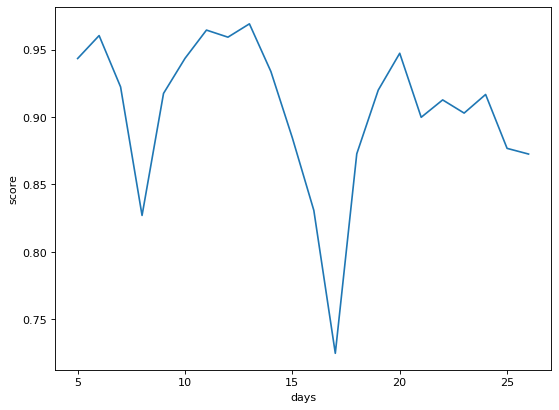

In [71]:
# alldays=list(range(31))
alldayscores= []
for i in range(4,26):#26
    alldaysx = list(range(i-5,i))# [x for j,x in enumerate(alldays) if j!=i]

    
    time_series_x_pre = np.array(time_series.iloc[:,alldaysx]) # get 'time series' dataframe for days 8, 10, 11, 12, 13
    time_series_y_post = time_series.iloc[:,i].values # get 'time series' dataframe for 14th



    time_series_x_pre,time_series_y_post=remove_nans(time_series_x_pre,time_series_y_post)
    
    if i == 16:
        ypred17=reg.predict(time_series_x_pre)
        yactual17 =time_series_y_post
    #print(reg.score(time_series_x_pre,time_series_y_post))
    alldayscores.append(reg.score(time_series_x_pre,time_series_y_post))
    # print(i,reg.score(time_series_x_pre,time_series_y_post))

figure(figsize=(8, 6), dpi=80)
# plt.xticks(list(range(5,31)))
plt.plot(np.arange(4,26)+1,alldayscores)
plt.xlabel('days')
plt.ylabel('score')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

Text(0, 0.5, 'y')

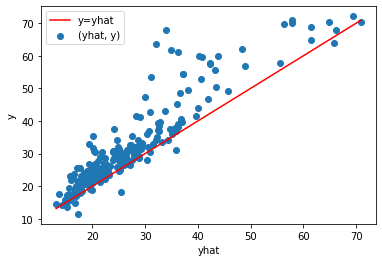

In [72]:

plt.figure()
plt.scatter(ypred17, yactual17, label = "(yhat, y)")
cmin  =max(np.min(ypred17), np.min(yactual17))
cmax = min(np.max(ypred17),np.max(yactual17))
plt.plot([cmin,cmax],[cmin,cmax],
color ="red",
label = "y=yhat")
plt.legend()
plt.xlabel('yhat')
plt.ylabel('y')

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [73]:
time_series_delta = time_series_pre-speeds_daily[:13]#time_series_pre.mean().values#... # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,-7.436210,-7.929735,-7.957726,-7.706332,-7.673488,-8.288859,-7.342673,-7.838718,-8.163539,-7.950124,-9.037052,-8.687048,-9.364599
20,-6.215082,-6.863900,-6.363125,-6.511982,-6.693731,-6.873540,-5.762984,-5.960594,-6.830754,-7.366163,-8.139844,-8.795882,-8.883074
21,-8.491956,-9.147858,-8.044932,-7.879632,-7.907553,-8.464493,-8.893040,-9.407162,-7.392644,-7.811186,-8.986853,-8.505135,-8.143181
44,1.446417,1.167730,0.901289,0.342397,-0.110985,0.981564,0.024509,1.604391,0.492527,0.078211,0.979607,1.910786,-0.144157
78,-7.458664,-5.569360,-5.787301,-5.813345,-6.320619,-6.303126,-7.548693,-4.765377,-6.755502,-6.530367,-7.003837,-6.987069,-7.112274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,-3.385687,-4.313850,0.621691,NaN,-3.970859,NaN,NaN,-0.971484,NaN
2694,-5.823366,-5.598968,-5.295639,-5.485229,-5.482634,-5.448377,-5.423980,-5.992169,-5.698587,-5.662927,-5.885166,-6.070161,-5.761289
2695,-3.527067,-2.096006,-1.977287,-1.785869,0.371917,-2.850371,-3.627592,-4.578175,-2.511783,-2.260573,1.093583,-2.863087,-2.977301


In [75]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)

linear_model_delta = LinearRegression(fit_intercept=True)
reg_delta = linear_model_delta.fit(X_delta_train, y_delta_train) 
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [77]:
time_series_delta_all= time_series-speeds_daily 
a=time_series.iloc[:,[11,12,13,14,15]] #time_series.iloc[:,[11,12,13,14,15]]
prev5speeddaily=speeds_daily[11:16]
fiveprevdays=[11,12,13,14,15]

for n in fiveprevdays:
    a.loc[:,n+1]=a.loc[:,n+1]-prev5speeddaily[n+1]

time_series_x_deltaX= np.array(a) # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_deltad17 = np.array(time_series.iloc[:,16]-speeds_daily[17])# time_series_delta_all.iloc[:,16].values # get 'time series' dataframe for 14th

time_series_x_deltaX,time_series_y_deltad17=remove_nans(time_series_x_deltaX,time_series_y_deltad17)

res_4ci4=reg_delta.score(time_series_x_deltaX, time_series_y_deltad17)
res_4ci4

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


0.8346539614612526

In [79]:
# time_series_delta_all= time_series-speeds_daily 
a14=time_series.iloc[:,[ 8,9,10,11,12]] #time_series.iloc[:,[9,10,11,12,13]] #time_series.iloc[:,[11,12,13,14,15]]
prev5speeddaily=speeds_daily[8:13]
fiveprevdays=[9,10,11,12,13]

for n in fiveprevdays:
    a14.loc[:,n]=a14.loc[:,n]-prev5speeddaily[n]

time_series_x_deltaX14= np.array(a14) # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_deltad14 = np.array(time_series.iloc[:,13]-speeds_daily[13])# time_series_delta_all.iloc[:,16].values # get 'time series' dataframe for 14th

time_series_x_deltaX14,time_series_y_deltad14=remove_nans(time_series_x_deltaX14,time_series_y_deltad14)

res_4ci5=reg_delta.score(time_series_x_deltaX14, time_series_y_deltad14)

res_4ci5



/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


0.9325752838883045

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see.
<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [81]:
time_series_post=time_series.loc[:,list(range(14,32))]

X_train1, y_train1, X_val2, y_val2 = time_series_to_dataset(time_series_post, 5, 0)
score_og_post = reg.score(X_train1, y_train1)
score_og_post




0.9014738674628208

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31.

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [83]:
newdataset = time_series.iloc[:,list(range(13,31))]
X_train, y_train, X_val, y_val = time_series_to_dataset(newdataset, 5, 2)
linear_model = LinearRegression(fit_intercept=True)
reg = linear_model.fit(X_train,y_train) #... # set to trained linear model
y_fitted_m1 = reg.predict(X_train)
y_predicted_m1 = reg.predict(X_val)
TSS=np.sum((y_val-np.mean(y_val))**2)
RSS=np.sum((y_val-y_predicted_m1)**2)
score_post = 1-(RSS/TSS)
score_post


0.8993687576351703

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [85]:
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series, 5, 5)
linear_model = LinearRegression(fit_intercept=True)
reg = linear_model.fit(X_train,y_train) #... # set to trained linear model
res_4civ = reg.score(X_val,y_val)
res_4civ

0.8843433608623491

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [100]:
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge

speeds_dists_path = 'speeds_dists.csv'
speeds_dists_path = pd.read_csv(speeds_dists_path)
speeds_dists_path.head(5)

def sigmoid(x):
    return 1/(1+np.exp(-x))


def applyohenc(df,variables):
    
    for i in range(len(variables)):
        oh_enc = OneHotEncoder()
        oh_enc.fit(df[[variables[i]]])
        oh_enc.transform(df[[variables[i]]].head())
        oh_enc.transform(df[[variables[i]]].head()).todense()
        oh_enc.get_feature_names()
    
        dummies = pd.DataFrame(oh_enc.transform(df[[variables[i]]]).todense(),
                    columns=oh_enc.get_feature_names(),
                    index = df.index)
    
        df=df.join(dummies)
    
    return df


def rmse(y_pred, y):
    return np.sqrt(np.mean((y_pred - y)**2))

Basic model 

R2training:0.9621679700538135
R2:0.9791817632132602
Training RMSE:  0.65881453411577
Testing RMSE:  0.5586943535526274


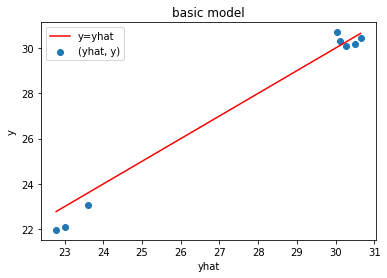

In [101]:
smalldata=speeds_dists_path.groupby('day').agg({'speed_mph_mean':'mean','distance':'mean','dist_to_SF':'mean'}).reset_index()
smalldata['is_lockdown']= smalldata['day']>13
smalldata['sigday']= sigmoid(smalldata['day'])

smalldata.replace({'is_lockdown':False},'preL',inplace=True)
smalldata.replace({'is_lockdown':True},'postL',inplace=True)
smalldata['ispostlockdownint']=speeds_dists_path['day']>13
weekends = np.array([1,7,8,14,15,21,22,28,29])

smalldata['is_weekend'] = smalldata['day'].apply(lambda x: any(x == weekends)).astype(int)
smalldata['is_weekend_int'] = smalldata['day'].apply(lambda x: any(x == weekends)).astype(int)
smalldata['is_weekend'] = smalldata['is_weekend'].replace({1:'Weekend', 0:'Weekday'})


df= applyohenc(smalldata,['is_weekend','is_lockdown'])


X_open = df.drop("speed_mph_mean",axis=1)[['day','distance']]
y_open = df["speed_mph_mean"]



X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_open, y_open)
model_1 = lm.LinearRegression()
model_1.fit(X_train_1, y_train_1)
y_pred_train_1 = model_1.predict(X_train_1)
y_pred_val_1 = model_1.predict(X_val_1)

modscore_training_1 = model_1.score(X_train_1,y_train_1)
modscore_1 = model_1.score(X_val_1,y_val_1)
print('R2training:'+str(modscore_training_1))
print('R2:'+str(modscore_1))

plt.figure()
plt.scatter(y_pred_val_1, y_val_1, label = "(yhat, y)")
cmin  =max(np.min(y_pred_val_1), np.min(y_val_1))
cmax = min(np.max(y_pred_val_1),np.max(y_val_1))
plt.plot([cmin,cmax],[cmin,cmax],
color ="red",
label = "y=yhat")
plt.legend()
plt.xlabel('yhat')
plt.ylabel('y')
plt.title('basic model')
print('Training RMSE: ', rmse(y_pred_train_1, y_train_1))
print('Testing RMSE: ', rmse(y_pred_val_1, y_val_1))

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

R2training:0.9852255825676789
R2:0.9688038274495351
Training RMSE:  0.4132098220078352
Testing RMSE:  0.5576373479503787


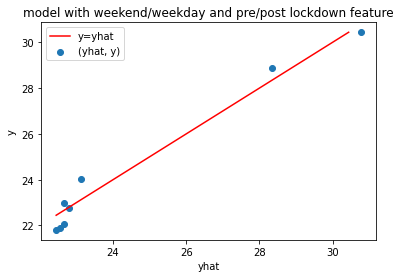

In [103]:


X_open = df.drop("speed_mph_mean",axis=1)[['day','distance','x0_Weekday','x0_Weekend','x0_postL','x0_preL']]
y_open = df["speed_mph_mean"]



X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_open, y_open)
model_1 = lm.LinearRegression()
model_1.fit(X_train_1, y_train_1)
y_pred_train_1 = model_1.predict(X_train_1)
y_pred_val_1 = model_1.predict(X_val_1)

modscore_training_1 = model_1.score(X_train_1,y_train_1)
modscore_1 = model_1.score(X_val_1,y_val_1)
print('R2training:'+str(modscore_training_1))
print('R2:'+str(modscore_1))

plt.figure()
plt.scatter(y_pred_val_1, y_val_1, label = "(yhat, y)")
cmin  =max(np.min(y_pred_val_1), np.min(y_val_1))
cmax = min(np.max(y_pred_val_1),np.max(y_val_1))
plt.plot([cmin,cmax],[cmin,cmax],
color ="red",
label = "y=yhat")
plt.legend()
plt.xlabel('yhat')
plt.ylabel('y')
plt.title('model with weekend/weekday and pre/post lockdown feature')
print('Training RMSE: ', rmse(y_pred_train_1, y_train_1))
print('Testing RMSE: ', rmse(y_pred_val_1, y_val_1))


# df= applyohenc(speeds_dists_path,['is_weekend','ispostlockdown'])
# intterm=pd.DataFrame(df['distance']*df['ispostlockdownint'])
# df['intterm']=intterm

# df['logdist'] = sigmoid(df['distance'])
# df['logspeed'] =(df['speed_mph_mean'])-np.mean(df['speed_mph_mean'][df['x0_Weekend']==1])
# df['sinday'] = np.sin(df['day'])


# X_open = df.drop("speed_mph_mean",axis=1)[['day','dist_to_SF','distance','x0_postL','x0_preL','x0_Weekend','x0_Weekday']]
# y_open = df["speed_mph_mean"]

# X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_open, y_open,test_size=0.33)
# model_1 = lm.LinearRegression()
# model_1.fit(X_train_1, y_train_1)
# y_pred_train_1 = model_1.predict(X_train_1)
# y_pred_val_1 = model_1.predict(X_val_1)

# modscore_training_1 = model_1.score(X_train_1,y_train_1)

# modscore_1 = model_1.score(X_val_1,y_val_1)
# print('R2:'+str(modscore_1))
# print('R2training:'+str(modscore_training_1))

# def rmse(y_pred, y):
#     return np.sqrt(np.mean((y_pred - y)**2))

# print('Training RMSE: ', rmse(y_pred_train_1, y_train_1))
# print('Testing RMSE: ', rmse(y_pred_val_1, y_val_1))


# # y_pred_val = model.predict(X_val)

# plt.figure()
# plt.scatter(y_pred_val_1, y_val_1, label = "(yhat, y)")
# cmin  =max(np.min(y_pred_val_1), np.min(y_val_1))
# cmax = min(np.max(y_pred_val_1),np.max(y_val_1))
# plt.plot([cmin,cmax],[cmin,cmax],
# color ="red",
# label = "y=yhat")
# plt.legend()
# plt.xlabel('yhat')
# plt.ylabel('y')
# plt.title('model with weekend/weekday and pre/post lockdown feature')

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

R2training:0.9879112220180132
R2:0.9624213858533718
Training RMSE:  0.40144613491657993
Testing RMSE:  0.6334954912622162


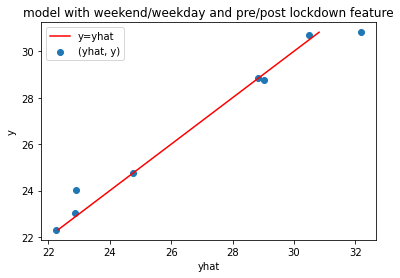

In [105]:


smalldata=speeds_dists_path.groupby('day').agg({'speed_mph_mean':'mean','distance':'mean','dist_to_SF':'mean'}).reset_index()
smalldata['is_lockdown']= smalldata['day']>13
smalldata['sigday']= sigmoid(smalldata['day'])


smalldata.replace({'is_lockdown':False},'preL',inplace=True)
smalldata.replace({'is_lockdown':True},'postL',inplace=True)
smalldata['ispostlockdownint']=speeds_dists_path['day']>13
weekends = np.array([1,7,8,14,15,21,22,28,29])

smalldata['is_weekend'] = smalldata['day'].apply(lambda x: any(x == weekends)).astype(int)
smalldata['is_weekend_int'] = smalldata['day'].apply(lambda x: any(x == weekends)).astype(int)
smalldata['is_weekend'] = smalldata['is_weekend'].replace({1:'Weekend', 0:'Weekday'})




df= applyohenc(smalldata,['is_weekend','is_lockdown'])


X_open = df.drop("speed_mph_mean",axis=1)[['day','distance','x0_Weekday','x0_Weekend','x0_postL','x0_preL']]
y_open = df["speed_mph_mean"]



X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_open, y_open)
model_1 = lm.LinearRegression()
model_1.fit(X_train_1, y_train_1)
y_pred_train_1 = model_1.predict(X_train_1)
y_pred_val_1 = model_1.predict(X_val_1)

modscore_training_1 = model_1.score(X_train_1,y_train_1)
modscore_1 = model_1.score(X_val_1,y_val_1)
print('R2training:'+str(modscore_training_1))
print('R2:'+str(modscore_1))

plt.figure()
plt.scatter(y_pred_val_1, y_val_1, label = "(yhat, y)")
cmin  =max(np.min(y_pred_val_1), np.min(y_val_1))
cmax = min(np.max(y_pred_val_1),np.max(y_val_1))
plt.plot([cmin,cmax],[cmin,cmax],
color ="red",
label = "y=yhat")
plt.legend()
plt.xlabel('yhat')
plt.ylabel('y')
plt.title('model with weekend/weekday and pre/post lockdown feature')
print('Training RMSE: ', rmse(y_pred_train_1, y_train_1))
print('Testing RMSE: ', rmse(y_pred_val_1, y_val_1))

